In [15]:
%matplotlib inline

# dependencies = {
#     "numpy":"np",
#     'os':None,
#     "PIL":["Image"],
#     "IPython":["display"],
#     "plotly.graph_objects":"go",
#     "subprocess":None
# }

# for d in dependencies.items():
#     print(d)
#     if d[1]:
#         if type(d[1]) == list:
#             __import__(d[0], fromlist=d[1])
#             _temp = __import__(d[0], globals(), locals(), d[1], 0)
#         else:
#             globals()[d[1]] = __import__(d[0])
#     else:
#         __import__(d[0], globals(), locals(),level=0)
        
!1>/dev/null pip install \
jupyter \
numpy \
pillow \
plotly

import numpy as np
import os
import plotly.graph_objects as go
import subprocess
from colorsys import hls_to_rgb, rgb_to_hls
from IPython import display
from IPython.core.display import HTML
from PIL import Image
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
# subprocess.run('bash -l themer'.split(' '), stdout=subprocess.PIPE)#.stdout.decode('utf-8')

In [17]:

with open(f"{os.environ['HOME']}/.config/nitrogen/bg-saved.cfg", 'r') as wp_file:
    wp_file.readline()
    wp_path = wp_file.readline().split('=')[1].strip()
    
##### Use above or below mutually exclusively

# wp_path = f"{os.environ['HOME']}/Pictures/Wallpapers"

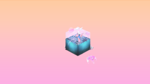

In [18]:
wp=Image.open(wp_path)
wp.thumbnail((150, 150))
pixels = np.array(wp)
display.display(wp)

In [19]:
colors=np.array([ color for _,color in wp.getcolors(wp.width * wp.height)], dtype=float)[:,:3]
Xs = colors[:,0]
Ys = colors[:,1]
Zs = colors[:,2]
# ipv.scatter(
#     Xs,
#     Ys,
#     Zs,
#     marker='sphere', color='blue')

# for color in [np.array([c]) for c in colors]:
# # for color in colors:
#     ipv.scatter(
#     color[0],
#     color[1],
#     color[2],
#     marker='sphere', color='blue')
#     print(color.shape)

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=Xs,
            y=Ys,
            z=Zs,
            mode='markers',
            marker=dict(
                size=3,
                color=colors,                # set color to an array/list of desired values
        #         colorscale='Viridis',   # choose a colorscale
                opacity=1.0
            )
        )
    ]
)

# tight layout
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
camera = dict(
    eye=dict(x=1, y=-2, z=1)
)
fig.update_layout(
    width=800, height=400,
    margin=dict(t=30, r=0, l=20, b=10),
    scene_camera=camera
)

fig.show()

In [20]:
dist=0.0
for i in range(len(colors)):
    for j in range(i,len(colors)):
        dist += np.sum(np.square(colors[i]-colors[j]))

dist /= len(colors)
dist = np.sqrt(dist)
dist

2959.2315733167407

In [21]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    metric='l2',
    alpha=150.0,
    cluster_selection_epsilon=150.0,
    min_cluster_size=10,
    gen_min_span_tree=True
)

print(clusterer)

def desaturate(rgb,alpha):
    hls = rgb_to_hls(*rgb)
    hls[2]*=alpha
    return hls_to_rgb(hls)
# fit_colors = [
#     desaturate(palette[col], sat) if col >= 0 else (0.5, 0.5, 0.5)
#     for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]`

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=150.0,
        approx_min_span_tree=True, cluster_selection_epsilon=150.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='l2', min_cluster_size=10, min_samples=None, p=None,
        prediction_data=False)


In [22]:
fits = clusterer.fit(colors)

# fit_colors = [
#     desaturate(palette[col], sat) if col >= 0 else (0.5, 0.5, 0.5)
#     for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]

fig = go.Figure(data=[go.Scatter3d(
    x=Xs,
    y=Zs,
    z=Ys,
    mode='markers',
    marker=dict(
        size=3,
        color=clusterer.labels_,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1.0
    )
)])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [23]:
cluster_n=clusterer.labels_.max()+1
clusters = np.array([(0,0,0)]*(cluster_n), dtype=float)
cluster_denoms = np.zeros(cluster_n)
for i in range(len(colors)):
    cluster_i = clusterer.labels_[i]
    if cluster_i < 0:
        continue
    clusters[cluster_i] += colors[i]
    cluster_denoms[cluster_i] += 1
for i in range(cluster_n):
    clusters[i] /= cluster_denoms[i]
    
cXs = clusters[:,0]
cYs = clusters[:,1]
cZs = clusters[:,2]
    
fig = go.Figure(data=[go.Scatter3d(
    x=cXs,
    y=cZs,
    z=cYs,
    mode='markers',
    marker=dict(
        size=6,
        color=clusters,                # set color to an array/list of desired values
        opacity=0.8
    )
)])
fig.show()


In [24]:
confidence_colors=[
    "rgba({0},{1},{2},{3})".format(*clusters[l,:],p) 
#     "rgba({0},{1},{2},{3})".format(*clusters[l,:],max(p-0.10,0)) 
    for l,p in zip(clusterer.labels_, clusterer.probabilities_)
]

fig = go.Figure(data=[go.Scatter3d(
    x=Xs,
    y=Zs,
    z=Ys,
    mode='markers',
    marker=dict(
        size=3,
        color=confidence_colors,                # set color to an array/list of desired values
        opacity=0.8
    )
)])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [25]:
methods = [
 'alpha',
 'cluster_persistence_',
 'condensed_tree_',
 'core_dist_n_jobs',
 'fit_predict',
 'generate_prediction_data',
 'get_params',
 'labels_',
 'leaf_size',
 'minimum_spanning_tree_',
 'outlier_scores_',
 'prediction_data',
 'prediction_data_',
 'probabilities_',
 'relative_validity_',
 'single_linkage_tree_'
]

# getattr(clusterer, methods[10])()

# print(clusterer.probabilities_)
# print(clusterer.labels_)
print(clusterer.leaf_size)


40


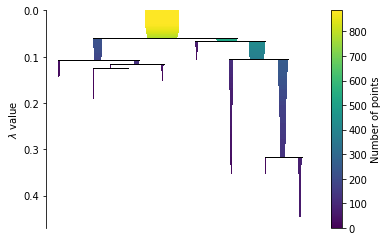

In [26]:
clusterer.condensed_tree_.plot()

In [27]:
rgb2hex = lambda rgb: '#%s' % ''.join(('%02x' % int(p) for p in rgb))

hues = list(map(lambda c: rgb_to_hls(*c), clusters))
hues.sort(key=lambda c: c[0])
hues = list(map(lambda c: hls_to_rgb(*c), hues))

HTML(
    "<br/>".join(
        ["<span style='background: {0}'> {0} </span>".format(rgb2hex(c)) for c in hues]
    )
)

# for i in range(cluster_n):
#     c=clusters[i]
# #     print(f"\x1b[48;2;{c[0]};{c[1]};{c[2]}m{rgb2hex(c)}\x1b[0m")
#     color=rgb2hex(c)
#     source+=f"<span style='background: {color}'> {color} </span>"
# HTML(source)

In [28]:
import plotly.express as px
import pandas as pd
df = pd.DataFrame(
    dict(
        r=[128,128,128],
        theta=['red','green','blue']
    )
)
fig = px.line_polar(
    df,
    r='r',
    theta='theta',
    line_close=True,
)
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 255]
    )),
  showlegend=False
)
def radargb(r,g,b):
    global fig
    
    fig.update_traces(
        fill='toself',
        fillcolor=f"rgb({r},{g},{b})"
    )
    
    fig.update(
        r=[r,g,b]
    )

    
    print(dir(fig))
    fig.update()
    fig.show()

for i in range(2):
    radargb(i,255,255)

# y = interact(radargb, r=(0,255), g=(0,255), b=(0,255) );

KeyError: 'r'